In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense


In [13]:
data = pd.read_csv('train.csv',parse_dates=True,index_col='datetime')
data.head()

,row_id,energy
datetime,,
2008-03-01 00:00:00,1,1259.985563
2008-03-01 01:00:00,2,1095.541500
2008-03-01 02:00:00,3,1056.247500
2008-03-01 03:00:00,4,1034.742000
2008-03-01 04:00:00,5,1026.334500


In [14]:
data.drop(columns=['row_id'],inplace=True)


In [15]:
data.isnull().sum()

energy    1900
dtype: int64

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94992 entries, 2008-03-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   energy  93092 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


In [17]:
data.fillna(method = 'ffill',inplace=True)
data.isnull().sum()

energy    0
dtype: int64

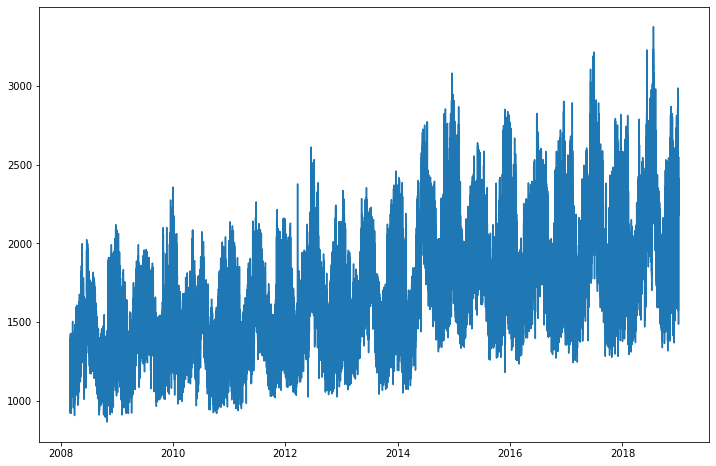

In [18]:
plt.figure(figsize = (12,8))
plt.plot(data)

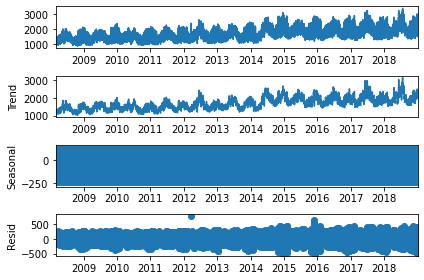

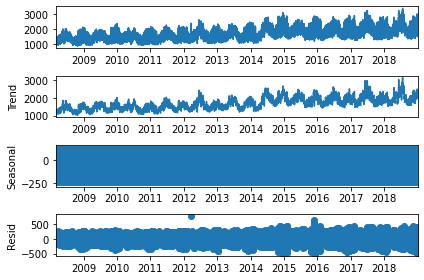

In [19]:
decompose = seasonal_decompose(data)
decompose.plot()

In [20]:
train1 = data[:7344]


In [21]:
train1.tail()

,energy
datetime,
2008-12-31 19:00:00,2027.2770
2008-12-31 20:00:00,1968.6240
2008-12-31 21:00:00,1927.0818
2008-12-31 22:00:00,1902.5622
2008-12-31 23:00:00,1771.2324


In [22]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train1)


In [23]:
train_scaled

array([[0.31444128],
       [0.18306831],
       [0.15167667],
       ...,
       [0.8473788 ],
       [0.8277903 ],
       [0.72287204]])

In [24]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_input = 24
n_features= 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=1)

In [25]:
x,y = generator[0]
x.shape, y.shape

((1, 24, 1), (1, 1))

In [26]:
lstm_model = Sequential()
lstm_model.add(LSTM(100,activation='relu',input_shape = (n_input,n_features)))
lstm_model.add(Dense(1))


In [27]:
lstm_model.compile(optimizer='adam',
              loss='mse'
              )

In [28]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [29]:
lstm_model.fit(generator,epochs=50,batch_size = 1000)

Epoch 1/50
7320/7320 [==============================] - 76s 10ms/step - loss: 0.0029
Epoch 2/50
7320/7320 [==============================] - 72s 10ms/step - loss: 7.6088e-04
Epoch 3/50
7320/7320 [==============================] - 72s 10ms/step - loss: 6.0748e-04
Epoch 4/50
7320/7320 [==============================] - 73s 10ms/step - loss: 5.2873e-04
Epoch 5/50
7320/7320 [==============================] - 72s 10ms/step - loss: 4.8905e-04
Epoch 6/50
7320/7320 [==============================] - 72s 10ms/step - loss: 4.5210e-04
Epoch 7/50
7320/7320 [==============================] - 74s 10ms/step - loss: 4.3981e-04
Epoch 8/50
7320/7320 [==============================] - 72s 10ms/step - loss: 4.2371e-04
Epoch 9/50
7320/7320 [==============================] - 74s 10ms/step - loss: 4.2399e-04
Epoch 10/50
7320/7320 [==============================] - 73s 10ms/step - loss: 4.0713e-04
Epoch 11/50
7320/7320 [==============================] - 73s 10ms/step - loss: 3.9809e-04
Epoch 12/50
7320/7320 [

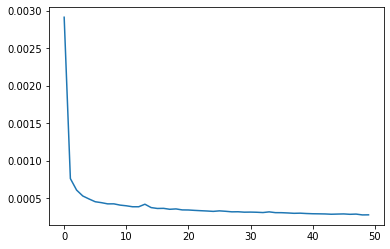

In [30]:
loss_per_epoch = lstm_model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [31]:
last_train_batch = train_scaled[-24:]

In [32]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [33]:
lstm_model.predict(last_train_batch)

1/1 [==============================] - 0s 240ms/step


array([[0.6129694]], dtype=float32)

In [35]:
valid2 = data[7344:7489]
valid_scaled = scaler.transform(valid2)

In [36]:
test_predictions = []

first_eval_batch = train_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(valid2)):
    
    # get the prediction value for the first batch
    current_pred = lstm_model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
     

1/1 [==============================] - 0s 24ms/step


In [37]:
test_predictions

[array([0.6129694], dtype=float32),
 array([0.51758265], dtype=float32),
 array([0.45314443], dtype=float32),
 array([0.3992454], dtype=float32),
 array([0.36304444], dtype=float32),
 array([0.35229552], dtype=float32),
 array([0.37775323], dtype=float32),
 array([0.4320748], dtype=float32),
 array([0.5068743], dtype=float32),
 array([0.5957736], dtype=float32),
 array([0.6951717], dtype=float32),
 array([0.79045904], dtype=float32),
 array([0.87544036], dtype=float32),
 array([0.9523151], dtype=float32),
 array([1.0184038], dtype=float32),
 array([1.073521], dtype=float32),
 array([1.1201748], dtype=float32),
 array([1.1523651], dtype=float32),
 array([1.1653951], dtype=float32),
 array([1.1570072], dtype=float32),
 array([1.1344008], dtype=float32),
 array([1.1060199], dtype=float32),
 array([1.0472212], dtype=float32),
 array([0.94135237], dtype=float32),
 array([0.8044908], dtype=float32),
 array([0.6989025], dtype=float32),
 array([0.6106025], dtype=float32),
 array([0.5183214], d

In [38]:

valid2.head()

,energy
datetime,
2009-01-01 00:00:00,1610.2674
2009-01-01 01:00:00,1471.4406
2009-01-01 02:00:00,1371.6864
2009-01-01 03:00:00,1301.6556
2009-01-01 04:00:00,1273.5198


In [39]:
true_predictions = scaler.inverse_transform(test_predictions)

In [40]:
valid2['Predictions'] = true_predictions

<ipython-input-40-a112e37d590b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid2['Predictions'] = true_predictions


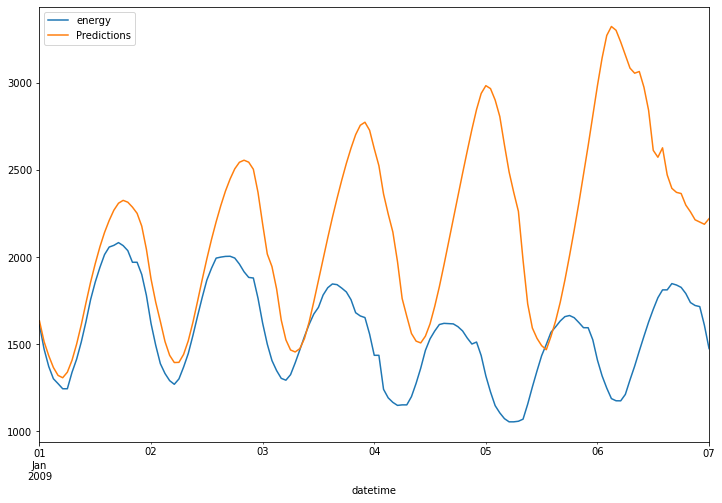

In [41]:
valid2.plot(figsize=(12,8))

In [42]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(valid2['energy'],valid2['Predictions']))
print(rmse)
     

822.4773050282038
